# GAN - Mario Project
## CS 445 - Rishi Shah, Steven Li

In [1]:
#Libraries Import

import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import cv2

In [2]:
# Directory containing the images
directory = "Original"
output_dir = "Blocks"

## Data Processing

In [24]:
def norm(arr):
    return (arr - arr.min()) / (arr.max() - arr.min()+1e-6)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ssd_score(im1, im2):
    return np.sum(((im1 - im2)**2))

In [4]:
block_dir = "block_types"
block_types = []
for i, file in enumerate(sorted(os.listdir(block_dir))):
  if file.split('.')[-1] != 'png':
    continue
  block_types.append(np.array(Image.open(os.path.join(block_dir, file)).convert('L')))


In [5]:
def encode_image(image, block_types, block_size = 16, block_threshold = .5):
    encoded_image = np.zeros(tuple([x // block_size for x in image.shape[:2]] + [len(block_types) + 1]), dtype=bool) # increase number of classes to number of different blocks, +1 for background

    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            curr_block = image[i:i+block_size, j:j+block_size]
            if curr_block.shape != (block_size, block_size):
                continue
            for k in range(len(block_types)):
                if ssd_score(curr_block[1:-1,1:-1], block_types[k][1:-1, 1:-1]) < block_threshold:
                    encoded_image[i // block_size, j // block_size, k] = 1
                    break
                else:
                    encoded_image[i // block_size, j // block_size, -1] = 1 # last layer is background

    return encoded_image

In [6]:
def decode_image(image, block_types, block_size = 16, block_threshold = .5):
    # need to complete
    decoded_image = np.zeros(tuple([x * block_size for x in image.shape[:2]]))

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        k = np.argmax(image[i, j, :])
        if k == len(block_types): # background
          continue
        else:
          decoded_image[i*16:i*16+16, j*16:j*16+16] = block_types[k]

    return decoded_image

In [7]:
# ONLY NEED TO RUN ONCE

processed_dir = "processed_images"
os.makedirs(processed_dir, exist_ok=True)
for existing_file in os.listdir(processed_dir):
    existing_filepath = os.path.join(processed_dir, existing_file)
    if os.path.isfile(existing_filepath):
        os.remove(existing_filepath)

# bad images
bad_images = ['mario-6-3.png', 'mario-8-3.png', 'mario-4-2.png', 'mario-1-2.png', 'mario-4-3.png', 'mario-5-3.png', 'mario-3-3.png', 'mario-1-3.png']

for file in os.listdir(directory):
  if file in bad_images:
    print(file)
    continue
  im = np.array(Image.open(os.path.join(directory, file)).convert('L'))
  output = encode_image(im, block_types)
  print(output.shape)
  # save as .npy or .pkl
  np.save(os.path.join(processed_dir, file), output)

(13, 202, 11)
mario-1-2.png
mario-1-3.png
(13, 197, 11)
(13, 197, 11)
(13, 208, 11)
mario-3-3.png
(13, 222, 11)
mario-4-2.png
mario-4-3.png
(13, 198, 11)
(13, 199, 11)
mario-5-3.png
(13, 184, 11)
(13, 215, 11)
mario-6-3.png
(13, 176, 11)
(13, 373, 11)
(13, 215, 11)
mario-8-3.png


In [8]:
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Block dimensions
block_width = 16
block_height = 16 # maybe pad height with 0s

count_of_images = 0
count_of_blocks = 0
for existing_file in os.listdir(output_dir):
    existing_filepath = os.path.join(output_dir, existing_file)
    if os.path.isfile(existing_filepath):
        os.remove(existing_filepath)


for file in os.listdir(processed_dir):
    filepath = os.path.join(processed_dir, file)
    # load numpy array
    data = np.load(filepath)
    top_padding = np.zeros((3, data.shape[1], data.shape[2]))
    top_padding[:, :, -1] = 1 # background
    data = np.append(top_padding, data, axis = 0) # padding to height 16

    # Get image dimensions
    img_width, img_height, _ = data.shape
    if img_width >= block_width and img_height >= block_height:
        count_of_images += 1
        for y in range(0, img_height, block_height):
            for x in range(0, img_width, block_width):
                # Ensure the block fits within the image
                if x + block_width <= img_width and y + block_height <= img_height:
                    # Crop the block
                    block = data[x:x+block_width, y:y+block_height, :].copy()

                    # Save the block
                    block_filename = f"{file.split('.')[0]}_block_{x}_{y}"
                    np.save(os.path.join(output_dir, block_filename), block)
                    count_of_blocks += 1

print("Count of Levels", count_of_images)
print("Training Images Avalible", count_of_blocks)

Count of Levels 12
Training Images Avalible 157


## GAN Setup and Traning


In [9]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# # Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [10]:
# Root directory for dataset
dataroot = output_dir

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 16

# Number of channels in the training images. For color images this is 3
nc = len(block_types) + 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [11]:
class Encoded_Im_Dataset(Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith(('.npy'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.files[idx]
        img = np.load(img_path).astype(np.float32)
        
        # Apply transformations, if any
        if self.transform:
            img = self.transform(img)
        
        return img

In [12]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = Encoded_Im_Dataset(dir=dataroot, transform=transforms.ToTensor())
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda")

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 4 x 4``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 8 x 8``
            nn.ConvTranspose2d( ngf, nc, 2, 1, 1, bias=False),
            nn.Softmax(dim=1) # originally tanh
            # state size. ``(nc) x 16 x 16``
        )

    def forward(self, input):
        output = self.main(input)
        binary_output = (output >= 0.5).float()  # Threshold at 0.5
        return binary_output


In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 11, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Sigmoi

In [16]:
# Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 16 x 16``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 8 x 8``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 2, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)


In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(11, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [18]:
# Custom Wasserstein Loss
def gradient_penalty(critic, real_data, fake_data, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)

    interpolated = real_data * epsilon + fake_data * (1 - epsilon)
    interpolated_scores = critic(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_scores, device=device),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()

    return penalty

In [19]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(5, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9 # not 1 and 0 to make discriminator slightly worse (maybe improve training)
fake_label = 0.1

lambda_gp = 10 # Gradient Penalty

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2*lr, betas=(beta1, 0.999)) # increased to make generator learn faster than discriminator

In [20]:
# Training Loop
from tqdm import tqdm

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    epoch_generator_loss = 0
    epoch_discriminator_loss = 0
    num_batches = 0

    for i, data in enumerate(dataloader):
        # Train the Discriminator more often than Generator
        for _ in range(5):  # 5 discriminator updates for each generator update
            optimizerD.zero_grad()

            # Real data
            real_data = data.to(device)
            real_scores = netD(real_data).view(-1)

            # Fake data
            noise = torch.randn(real_data.size(0), nz, 1, 1, device=device)
            fake_data = netG(noise)
            fake_scores = netD(fake_data.detach()).view(-1)

            # Gradient penalty
            gp = gradient_penalty(netD, real_data, fake_data, device)
            critic_loss_value = -(torch.mean(real_scores) - torch.mean(fake_scores)) + lambda_gp * gp

            # Backprop and optimize
            critic_loss_value.backward()
            optimizerD.step()

        # Train the Generator
        optimizerG.zero_grad()

        # Generate fake data
        noise = torch.randn(real_data.size(0), nz, 1, 1, device=device)
        fake_data = netG(noise)
        fake_scores = netD(fake_data).view(-1)

        # Generator loss
        generator_loss_value = -torch.mean(fake_scores)

        # Backprop and optimize
        generator_loss_value.backward()
        optimizerG.step()

        # Collecting the stats
        epoch_generator_loss += generator_loss_value.item()
        epoch_discriminator_loss += critic_loss_value.item()
        num_batches += 1

    # Save Losses for plotting later
    G_losses.append(epoch_generator_loss / num_batches)
    D_losses.append(epoch_discriminator_loss / num_batches)

    # check generator every 100 epochs
    if (epoch % (num_epochs // 50) == 0) or (epoch == num_epochs-1):
        with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
        img_list.append(fake)

Starting Training Loop...


100%|██████████| 8000/8000 [27:59<00:00,  4.76it/s]


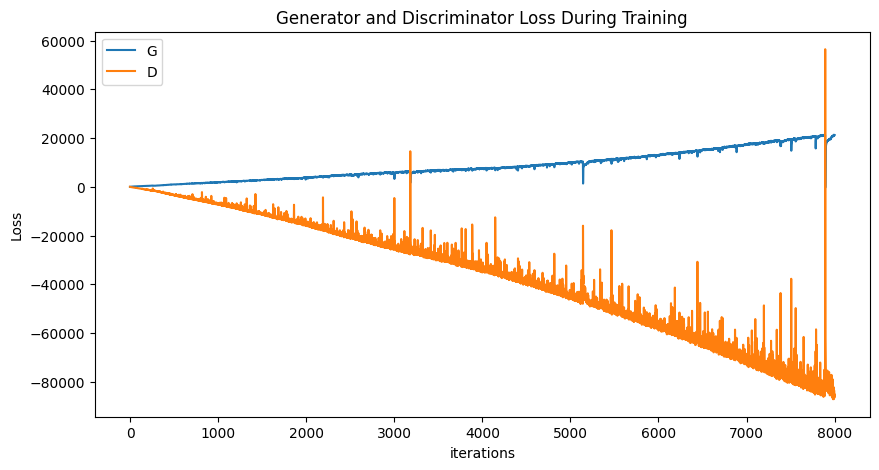

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

epoch num: 0


C:\Users\liste\AppData\Local\Temp\ipykernel_2020\1467860100.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


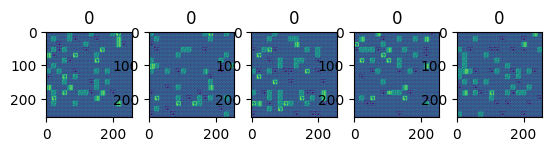

epoch num: 156


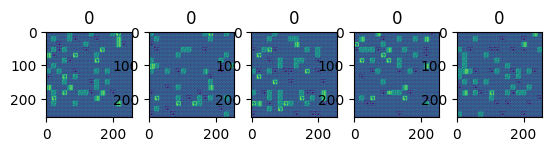

epoch num: 312


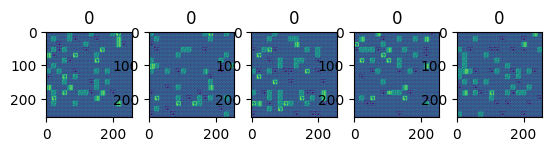

epoch num: 468


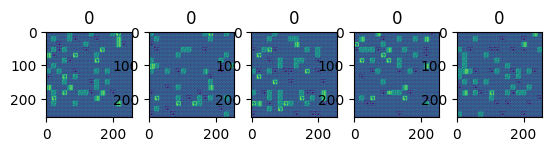

epoch num: 624


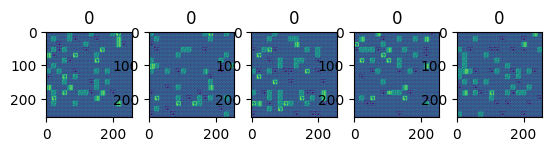

epoch num: 780


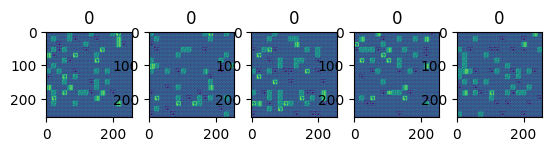

epoch num: 936


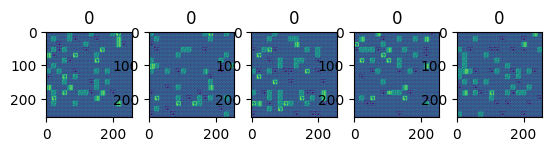

epoch num: 1092


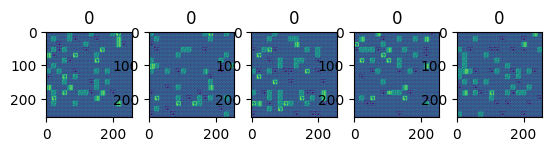

epoch num: 1248


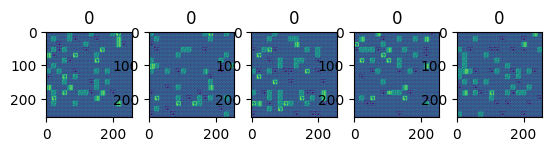

epoch num: 1404


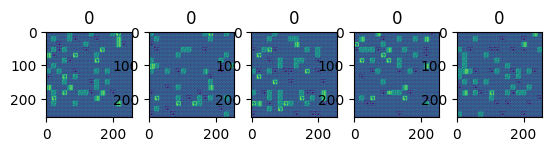

epoch num: 1560


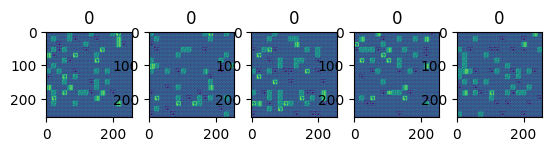

epoch num: 1716


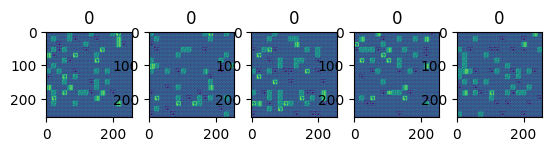

epoch num: 1872


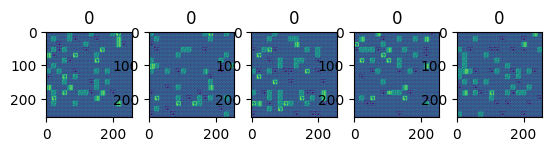

epoch num: 2028


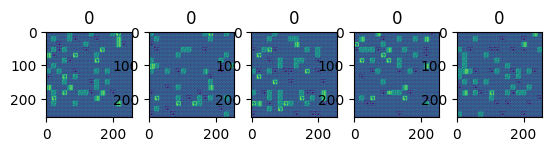

epoch num: 2184


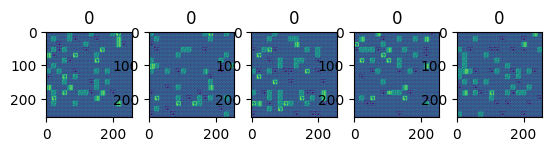

epoch num: 2340


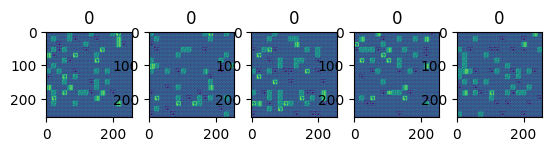

epoch num: 2496


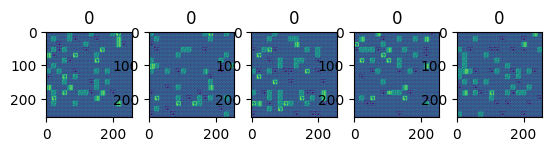

epoch num: 2652


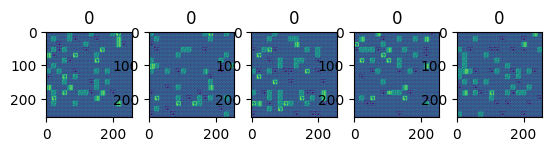

epoch num: 2808


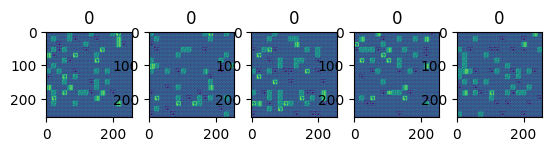

epoch num: 2964


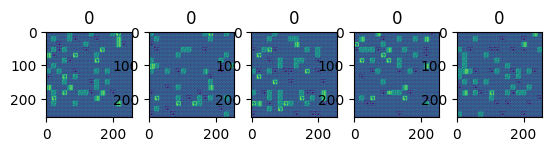

epoch num: 3120


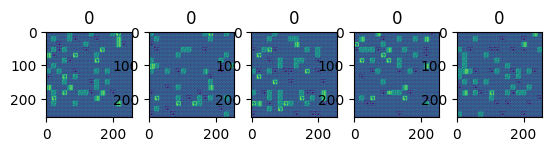

epoch num: 3276


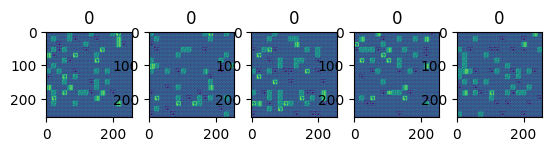

epoch num: 3432


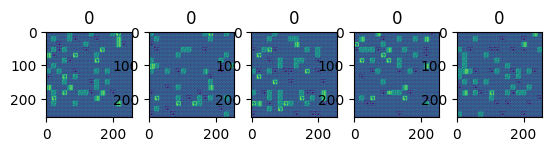

epoch num: 3588


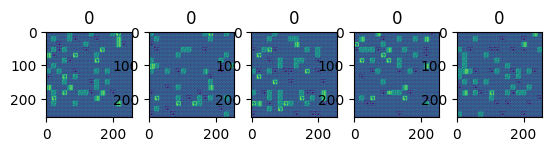

epoch num: 3744


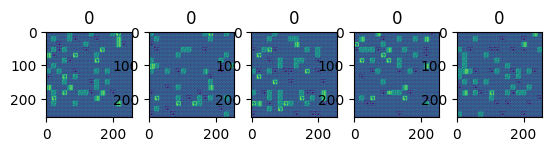

epoch num: 3900


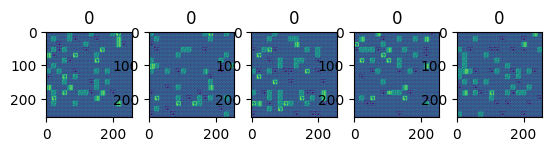

epoch num: 4056


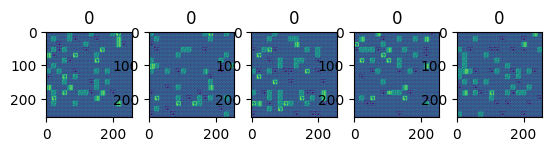

epoch num: 4212


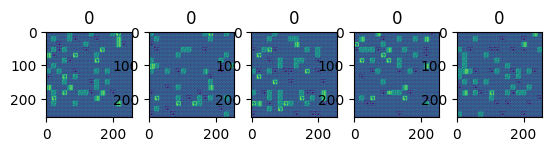

epoch num: 4368


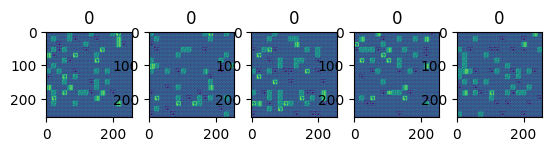

epoch num: 4524


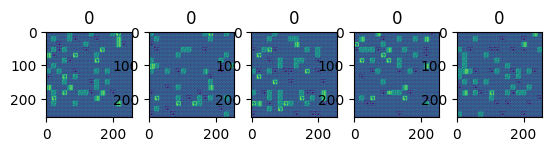

epoch num: 4680


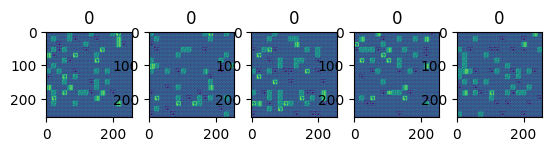

epoch num: 4836


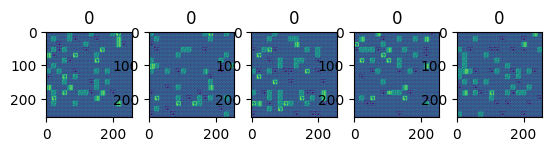

epoch num: 4992


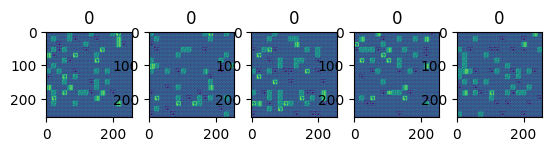

epoch num: 5148


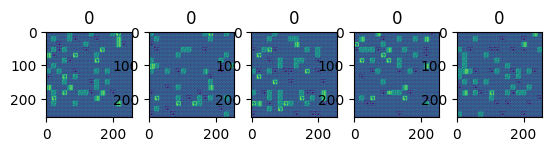

epoch num: 5304


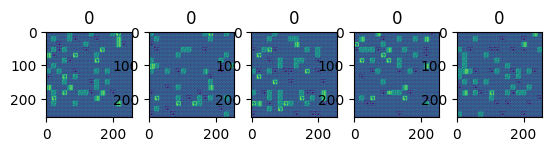

epoch num: 5460


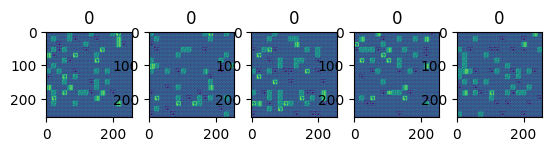

epoch num: 5616


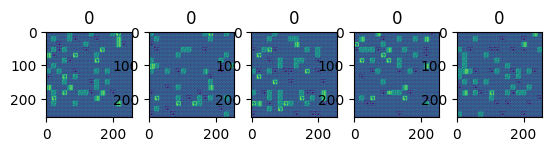

epoch num: 5772


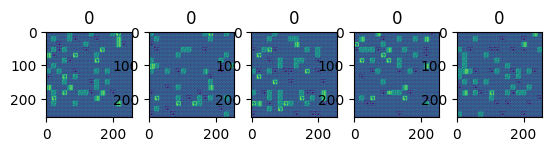

epoch num: 5928


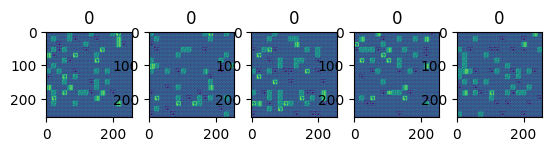

epoch num: 6084


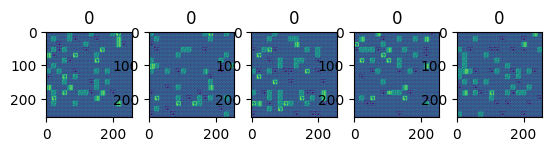

epoch num: 6240


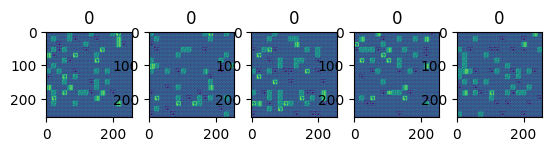

epoch num: 6396


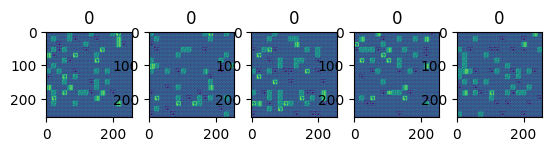

epoch num: 6552


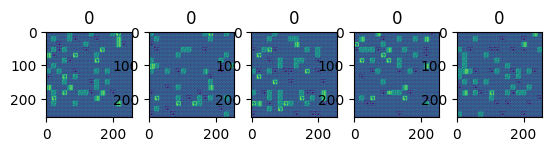

epoch num: 6708


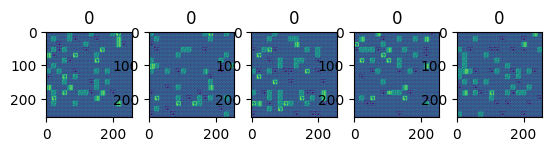

epoch num: 6864


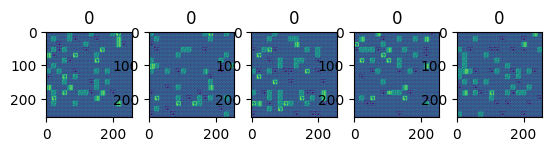

epoch num: 7020


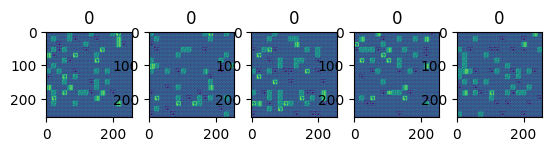

epoch num: 7176


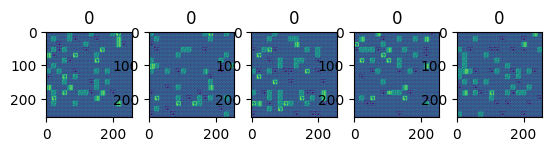

epoch num: 7332


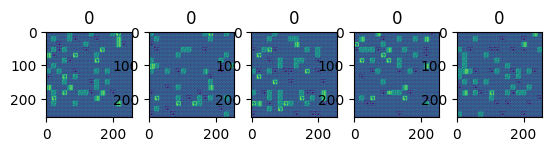

epoch num: 7488


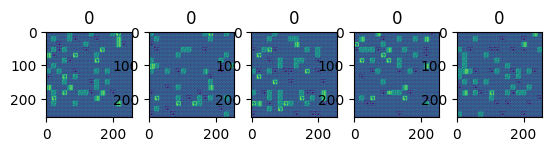

epoch num: 7644


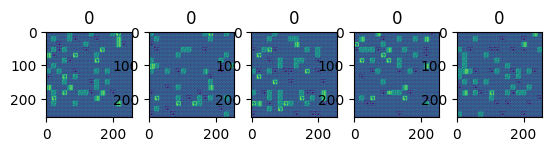

epoch num: 7800


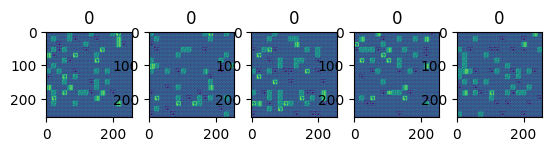

In [25]:
# Plot the fake images from the last epoch
for i in range(len(img_list)):
  print('epoch num:', i*(num_epochs // len(img_list)))
  current_images = img_list[i]
  num_pics = current_images.shape[0]
  fig, axes = plt.subplots(1, num_pics)
  for j in range(num_pics):
    axes[j].imshow(decode_image(np.transpose(img_list[i][j, :, :, :].numpy(), (1, 2, 0)), block_types))
    with torch.no_grad():
      axes[j].set_title(round(sigmoid(netD(torch.tensor(np.expand_dims(img_list[i][j, :, :, :], axis=0)).to(device)).detach().cpu().numpy().squeeze().item())))
  plt.show()